<h1> Full Width at Half Maximum Biomarkers in Lung MRI Imaging </h1>
<h3>Dataset: 12 phase registered image </h3>

In [1]:
%matplotlib notebook
import numpy as np
import nibabel as nib
import sigpy.plot as pl
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import find_peaks, peak_widths
from numpy.polynomial.polynomial import Polynomial

<h1> Loading the data...<h1>

In [2]:
#Load and deserialize numpy array 
workspace = np.load("20190923_vo1_pr_rec_Jac_fit_workspace.npy", allow_pickle=True).item()
workspace.keys()

dict_keys(['__header__', '__version__', '__globals__', 'D', 'Jac', 'Jac_fit', 'Jac_max', 'insp_reg', 'invD', 'lung_mask'])

In [8]:
#Load registered MRI image
registered = workspace['insp_reg']

In [9]:
#Load lung mask 
mask = workspace['lung_mask']

In [10]:
#Multiply lung mask with registered image 
registered_mask = np.empty((208, 128, 160, 6))
for i in range(6):
    registered_mask[:,:,:,i] = np.multiply(registered[:,:,:,i], mask)

In [11]:
#Remove unwanted pixels around the edge of registered lung image
#TODO Define thresholds for each time phase. Experiment with 0.05-0.08. Look into percentiles, like 95th. 
registered_mask = np.where(registered_mask < 0.06, registered_mask, 0)

<h1>Lung Mask Voxel Sample<h1>

In [12]:
#Generate a voxel sample given a size 
def voxel_sample(img, voxel_size):
    size = voxel_size
    x = img.shape[0] // size
    y = img.shape[1] // size
    z = img.shape[2] // size
    t = img.shape[3]
    sample = np.empty((x,y,z,t))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                for l in range(t):
                    sample[i, j, k, l] = np.mean(img[i*size:(i+1)*size, j*size:(j+1)*size, k*size:(k+1)*size, l:l+1])
    return sample

In [13]:
#Calculate 4, 2 voxel sample
voxel_sample_4 = voxel_sample(registered_mask, 4)
voxel_sample_2 = voxel_sample(registered_mask, 2)

<h1> Full Width at Half Max with no Curve Fitting<h1>

In [14]:
#Calculate full width half max
def calculate_full_width_half_max(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                    slice_1D = img[i,j,k,:]
                    peaks, _ = find_peaks(slice_1D)
                    results_half = peak_widths(slice_1D, peaks, rel_height=0.5)
                    if results_half[0].size == 0:
                        results_half = 0
                        sample[i, j, k] = results_half
                    else:
                        sample[i, j, k] = results_half[0][0]
    return sample

In [15]:
#Calculate full width half max without curve fitting
fwhm_4 = calculate_full_width_half_max(voxel_sample_4)

<IPython.core.display.Javascript object>


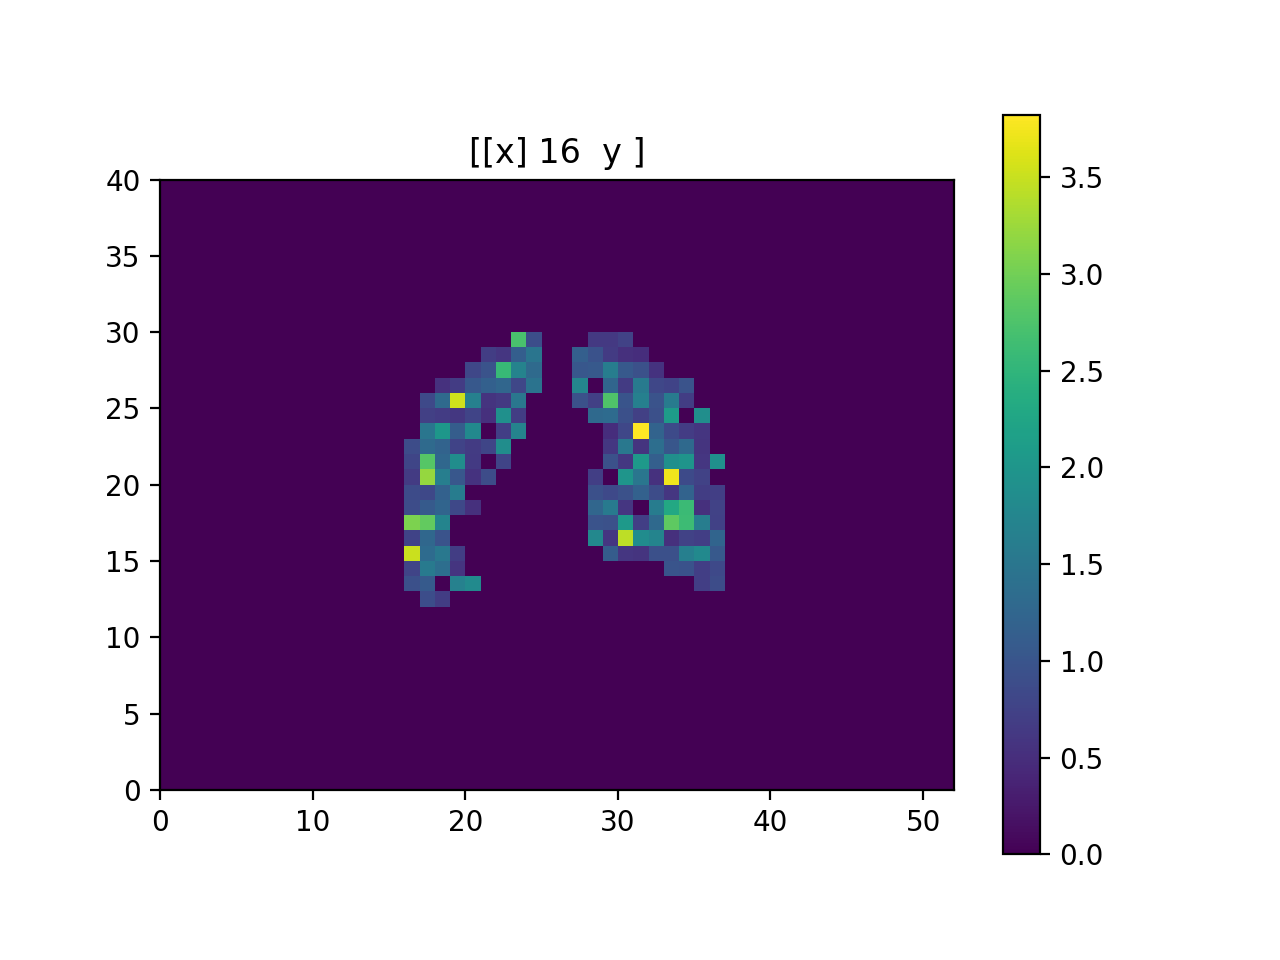

In [16]:
#Plot full width half max of a 4 voxel sample
pl.ImagePlot(fwhm_4, x=0, y=2, colormap ='viridis')

<h1> Full Width at Half Max with 3rd Degree Polynomial Curve Fitting <h1>

In [17]:
#Plot intensity with 3rd degree polyonimal curve fit
def plot_third_degree_poly_curve_fit(intensity_values):
    poly_x, poly_y = third_degree_poly_curve_fitting(intensity_values, 40)
    fig = plt.figure()
    plt.plot(np.arange(6), intensity_values, 'o', label='Intensity')
    plt.plot(poly_x, poly_y, label='3rd Degree Polynomial')
    plt.title('Time to Peak')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

In [18]:
#Computes 3rd degree polynomial values in [0,11]
def third_degree_poly_curve_fitting(y_values, samples):
    x_axis = np.linspace(0,5,6)
    poly_x_axis = np.linspace(0,5,num=samples)    
    poly_fit_function = np.poly1d(np.polyfit(x_axis, y_values, 3))
    
    return poly_x_axis, poly_fit_function(poly_x_axis)

In [26]:
#Calculates time to peak for 3rd degree polynomial curve fitting
def calculate_full_width_half_max_third_degree_poly(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))
    
    for i in range(x):
        for j in range(y):
            for k in range(z):
                    data = img[i, j, k, :]
                    fitted_x, fitted_y = third_degree_poly_curve_fitting(data, 10)
                    
                    peaks, _ = find_peaks(fitted_y)
                    results_half = peak_widths(fitted_y, peaks, rel_height=0.5)
                    if results_half[0].size == 0:
                        results_half = 0
                        sample[i, j, k] = results_half
                    else:
                        sample[i, j, k] = results_half[0][0]
    return sample

In [27]:
#Calculate time to peak with 3rd degree polynomial for a 4 voxel sample
full_width_half_max_third_degree_poly_4 = calculate_full_width_half_max_third_degree_poly(voxel_sample_4)

<IPython.core.display.Javascript object>


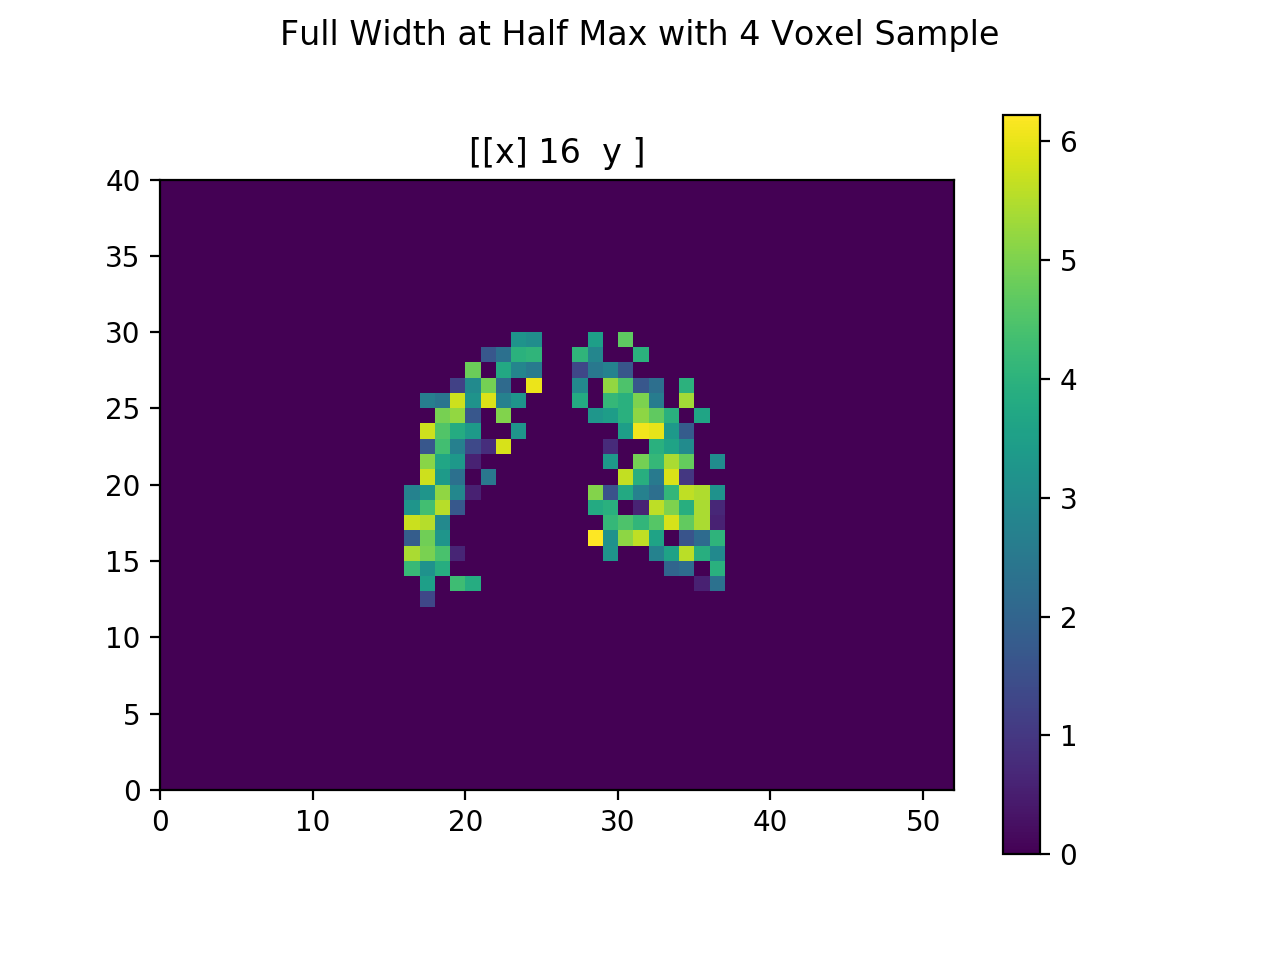

In [28]:
#Plot full width at half max of the registered mask
pl.ImagePlot(full_width_half_max_third_degree_poly_4, x=0, y=2, colormap ='viridis', title='Full Width at Half Max with 4 Voxel Sample')

In [29]:
#Calculate time to peak with 3rd degree polynomial for a 4 voxel sample
full_width_half_max_third_degree_poly_2 = calculate_full_width_half_max_third_degree_poly(voxel_sample_2)

<IPython.core.display.Javascript object>


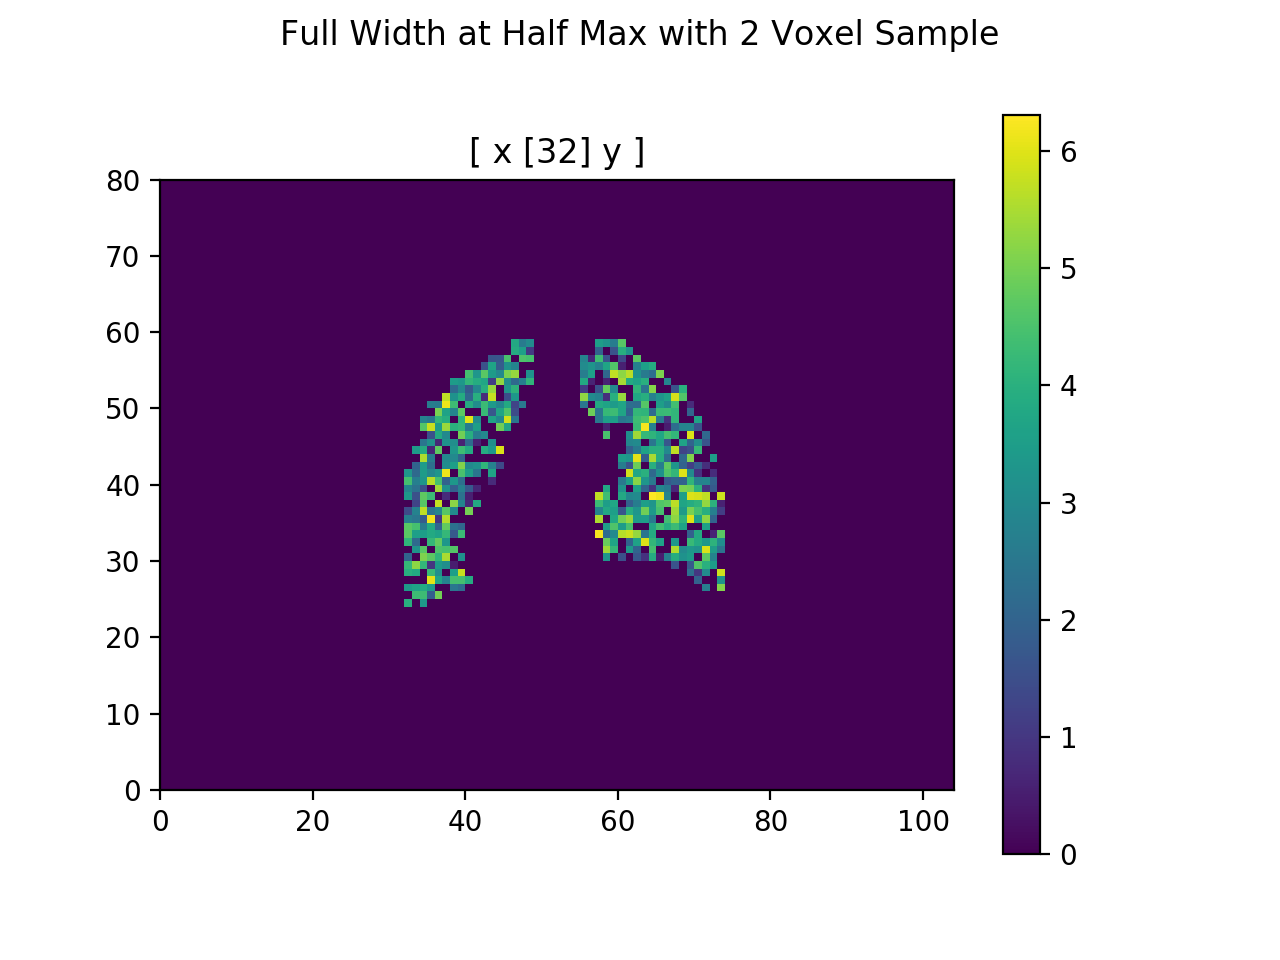

In [30]:
#Plot full width at half max of the registered mask
pl.ImagePlot(full_width_half_max_third_degree_poly_2, x=0, y=2, colormap ='viridis', title='Full Width at Half Max with 2 Voxel Sample')

<IPython.core.display.Javascript object>


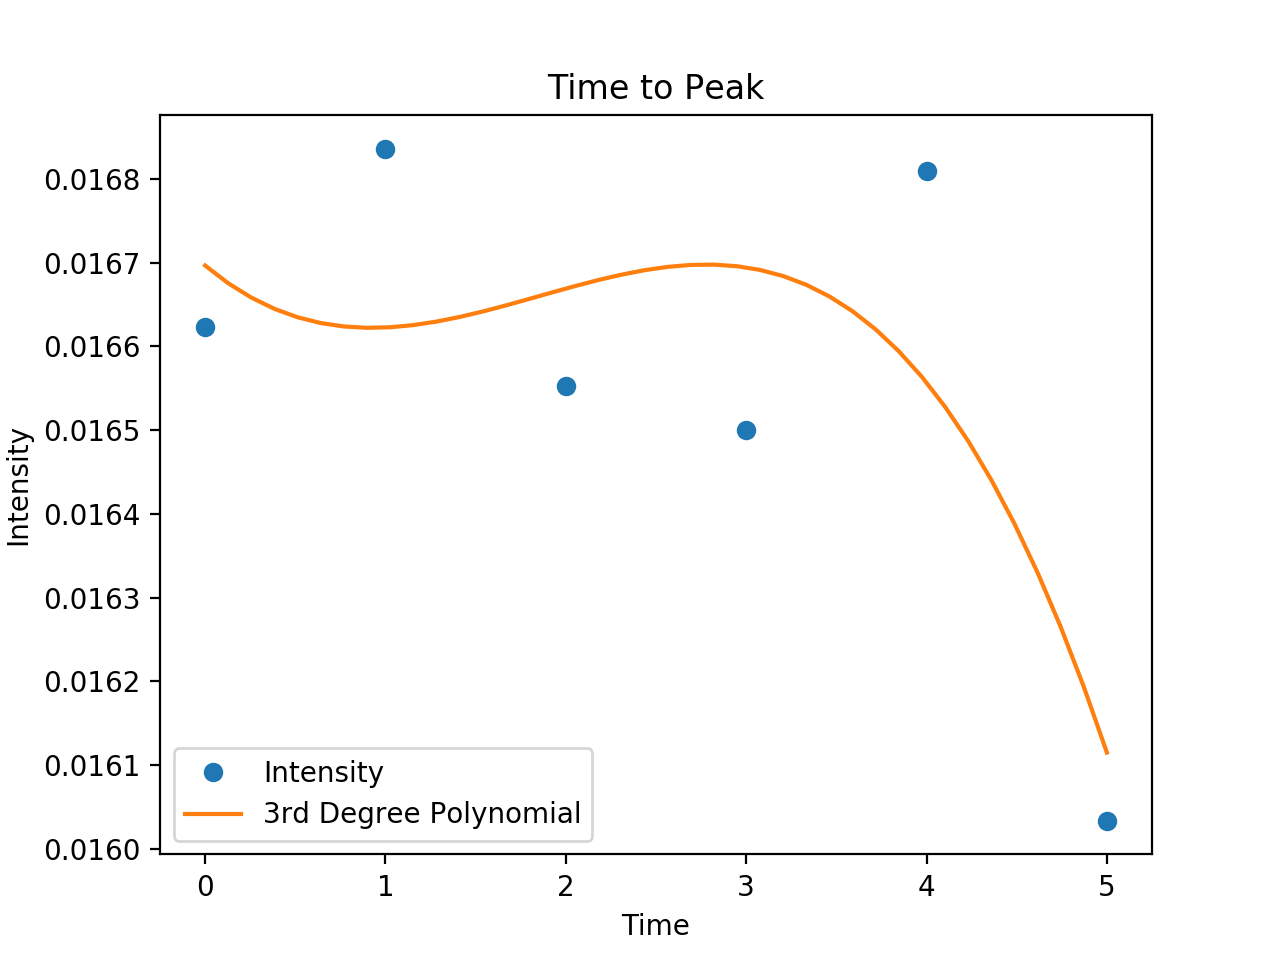

In [25]:
plot_third_degree_poly_curve_fit(voxel_sample_4[16,16,19,:])

<IPython.core.display.Javascript object>


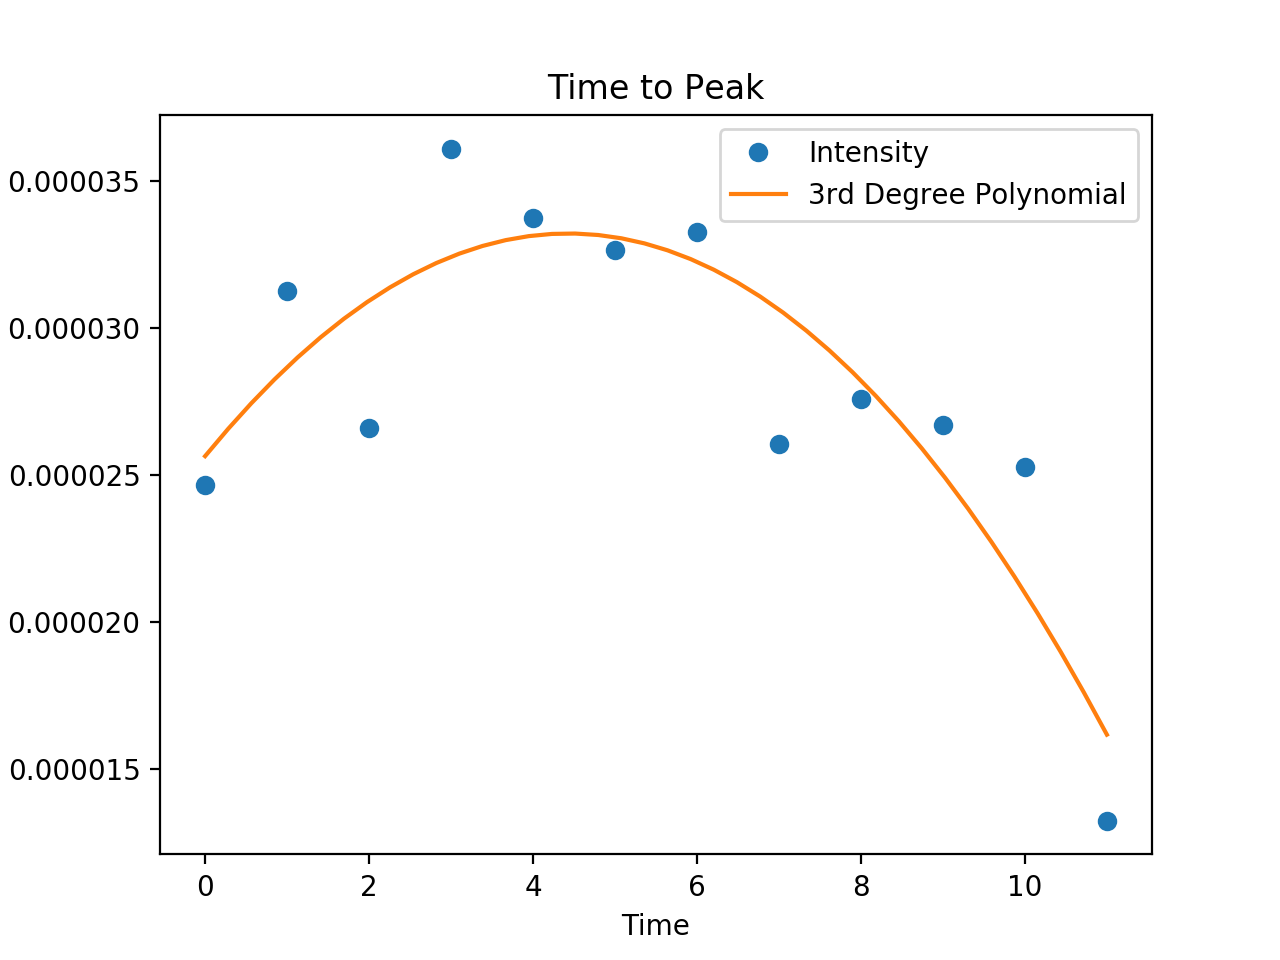

In [32]:
plot_third_degree_poly_curve_fit(voxel_sample_2[36,32,47,:])

<IPython.core.display.Javascript object>


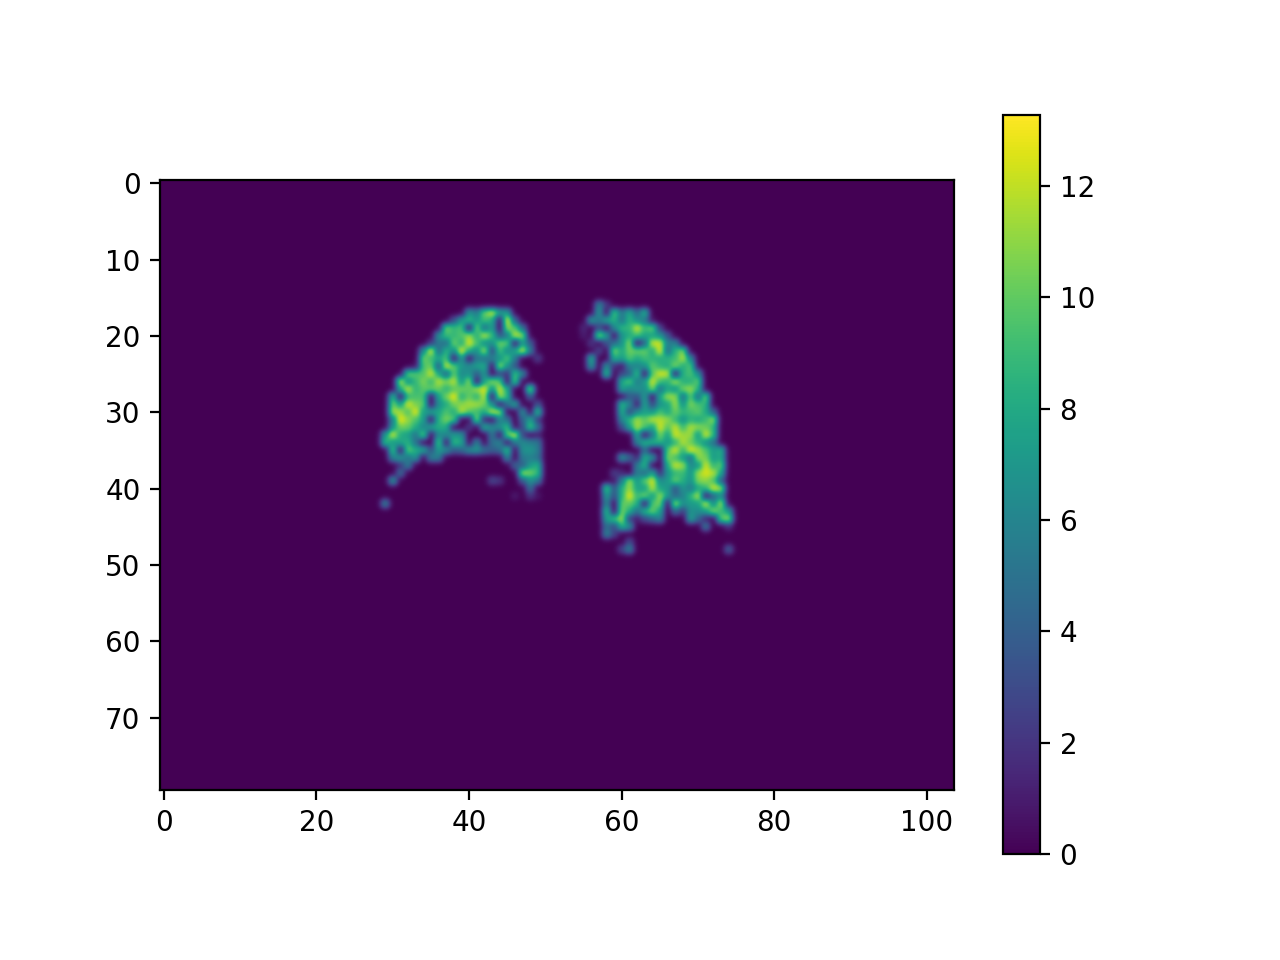

In [54]:
fig = plt.figure()
plt.imshow(np.flip(full_width_half_max_third_degree_poly_2[:,30,:].T), cmap='viridis', interpolation="gaussian")
plt.colorbar()

<IPython.core.display.Javascript object>


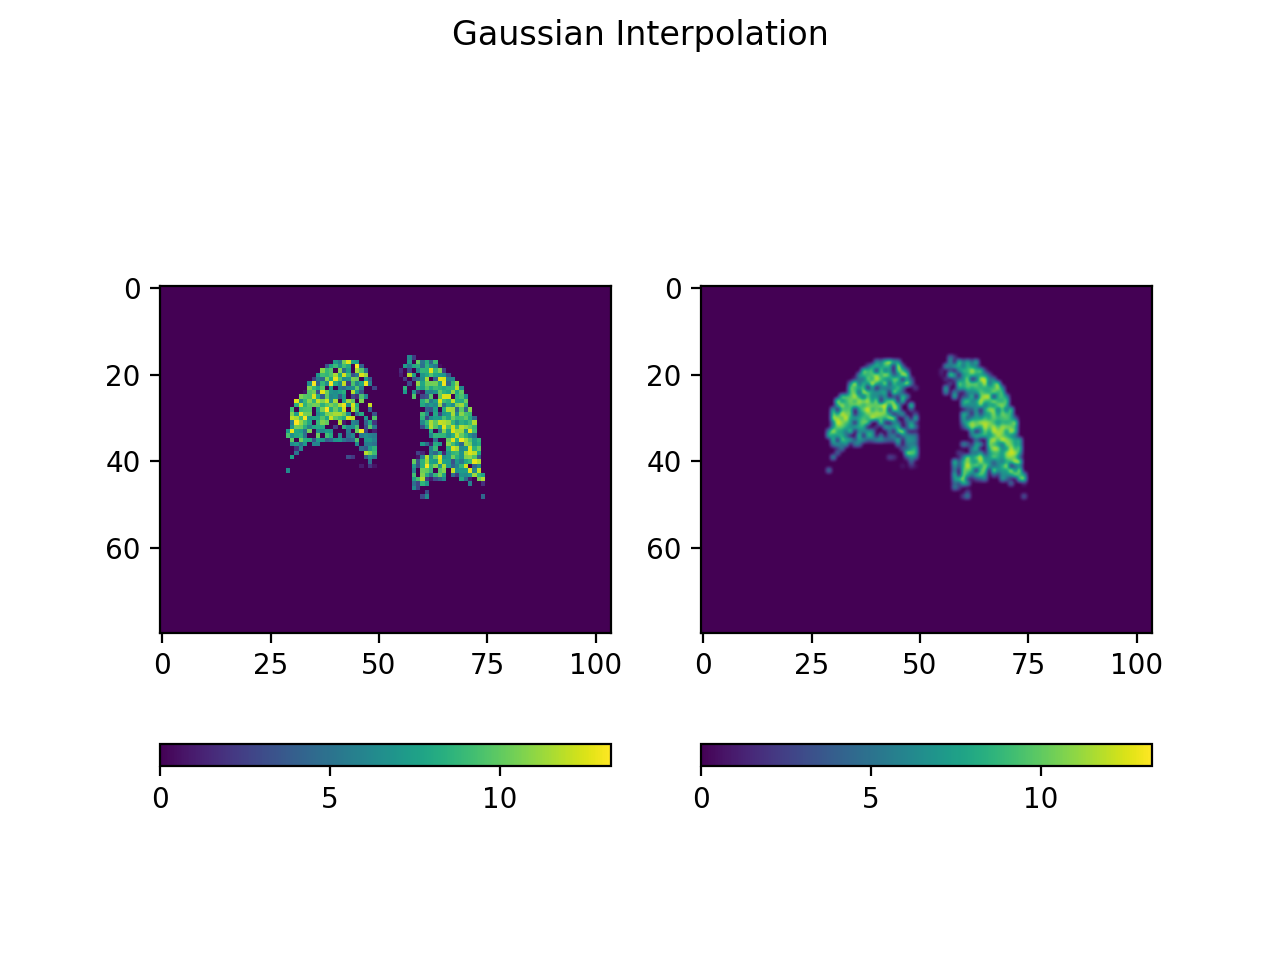

In [51]:
#Gaussian interpolations for imshow()
fig, axs = plt.subplots(1, 2)
subplots = [full_width_half_max_third_degree_poly_2[:,30,:], full_width_half_max_third_degree_poly_2[:,30,:]]
interp = [None, 'quadric']
fig.suptitle('Gaussian Interpolation')

for col in range(2):
    ax = axs[col]
    pcm = ax.imshow(np.flip(subplots[col].T), cmap='viridis', interpolation=interp[col])
    fig.colorbar(pcm, ax=ax, orientation='horizontal')
plt.show()